# Trả lời câu hỏi (ttd_ans_question)
Notebook này trả lời các câu hỏi dựa trên dữ liệu `data/raw/movies_dataset_enriched.csv` và một mô hình XGBoost (regression) dự đoán **log(revenue)**.

Các câu hỏi:
1) Phim có khả năng thu lời hay lỗ?  
2) Yếu tố nào ảnh hưởng doanh thu mạnh nhất?  
3) Khi nào là thời điểm tốt nhất để phát hành phim?  
4) Studio nào đang thống trị doanh thu?  
5) Nếu thêm một ngôi sao hạng A, doanh thu sẽ tăng bao nhiêu? Có đáng với chi phí thêm vào hay không?  
6) Thể loại nào đang tăng trưởng doanh thu nhanh nhất?

In [57]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

In [58]:
DATA_PATH = 'data/raw/movies_dataset_enriched.csv'
df_raw = pd.read_csv(DATA_PATH)
print('Loaded:', DATA_PATH)
print('Shape:', df_raw.shape)
df_raw.head(3)

Loaded: data/raw/movies_dataset_enriched.csv
Shape: (11187, 22)


,id,title,release_date,budget,revenue,runtime,rating,vote_count,popularity,genres,...,director,cast,keywords,original_language,collection,poster_brightness,poster_saturation,poster_dom_r,poster_dom_g,poster_dom_b
0,8358,Cast Away,2000-12-22,90000000,429632142,143,7.660,11912,7.0546,"Adventure, Drama",...,Robert Zemeckis,"Tom Hanks, Helen Hunt, Chris Noth, Paul Sanche...","exotic island, suicide attempt, volleyball, su...",en,NaN,104.25,58.37,104.0,86.0,80.0
1,98,Gladiator,2000-05-04,103000000,465516248,155,8.220,20234,16.4449,"Action, Drama, Adventure",...,Ridley Scott,"Russell Crowe, Joaquin Phoenix, Connie Nielsen...","gladiator, rome, italy, arena, senate, roman e...",en,Gladiator Collection,129.02,102.34,129.0,102.0,73.0
2,8871,How the Grinch Stole Christmas,2000-11-17,123000000,345800000,104,6.775,7940,25.2338,"Family, Comedy, Fantasy",...,Ron Howard,"Jim Carrey, Taylor Momsen, Jeffrey Tambor, Chr...","new love, based on novel or book, holiday, chr...",en,NaN,157.19,130.06,96.0,119.0,136.0


## 0) Chuẩn hoá + Feature Engineering (giữ gần với pipeline hiện có)
- Mục tiêu dự đoán: `log1p(revenue)` (giống notebook phân tích).
- Budget cũng `log1p` để ổn định phân phối.
- Các cột dạng list: tách theo dấu phẩy.
- Time-based target encoding cho: cast, director, keywords, genres, companies, countries, collection.

In [59]:
def _parse_list_safe(x):
    if pd.isna(x) or str(x).strip() == '':
        return []
    if isinstance(x, str):
        return [i.strip() for i in x.split(',')]
    return []

def _parse_collection_to_list(x):
    if pd.isna(x) or str(x).strip() == '':
        return []
    return [str(x).strip()]

def time_based_target_encoding(df_sorted, list_col_name, target_col, alpha=10):
    """
    Tính encoding dựa trên lịch sử quá khứ.
    - df: DataFrame ĐÃ ĐƯỢC SORT theo thời gian.
    - list_col_name: Cột chứa list (vd: cast, keywords).
    - target_col: Cột mục tiêu (log_revenue).
    - alpha: Hệ số làm mượt (smoothing factor).
    """
    global_mean = df_sorted[target_col].mean()

    # Dictionary lưu lịch sử: {'Tom Cruise': {'sum': 500, 'count': 5}}
    history = {}

    feature_values = []

    # Duyệt tuần tự theo thời gian
    for idx, row in df_sorted.iterrows():
        current_items = row[list_col_name]
        target_val = row[target_col]

        # DỰ ĐOÁN (Dựa trên quá khứ)
        stats = []
        for item in current_items:
            if item in history:
                rec = history[item]
                # Smoothed Mean: (Tổng doanh thu quá khứ + alpha * Global) / (Số phim quá khứ + alpha)
                mean_val = (rec['sum'] + alpha * global_mean) / (rec['count'] + alpha)
                stats.append(mean_val)
            else:
                stats.append(global_mean)

        # Tổng hợp điểm số cho bộ phim
        if stats:
            # Kết hợp: 70% sức mạnh ngôi sao lớn nhất (Max) + 30% sức mạnh tập thể (Mean)
            score = 0.7 * np.max(stats) + 0.3 * np.mean(stats)
        else:
            score = global_mean

        feature_values.append(score)

        #  (Cập nhật vào lịch sử cho phim sau dùng)
        if target_val > 0:
            for item in current_items:
                if item not in history:
                    history[item] = {'sum': 0.0, 'count': 0.0}
                history[item]['sum'] += target_val
                history[item]['count'] += 1.0
    return feature_values

def prepare_features(df_input):
    df = df_input.copy()

    # keep raw columns for business questions (NOT for model training)
    df['budget_raw'] = pd.to_numeric(df.get('budget'), errors='coerce')
    df['revenue_raw'] = pd.to_numeric(df.get('revenue'), errors='coerce')

    # target: log1p(revenue)
    df['revenue'] = np.log1p(df['revenue_raw'].clip(lower=0))

    # release date features
    df['release_date'] = pd.to_datetime(df.get('release_date'), errors='coerce')
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_dayofweek'] = df['release_date'].dt.dayofweek
    df['release_quarter'] = df['release_date'].dt.quarter
    df['is_weekend'] = df['release_dayofweek'].apply(lambda x: 1 if pd.notna(x) and x >= 5 else 0)
    df['is_blockbuster_season'] = df['release_month'].apply(lambda x: 1 if pd.notna(x) and x in [5, 6, 7, 11, 12] else 0)

    # list-like columns
    list_cols = ['genres', 'cast', 'production_companies', 'production_countries', 'director', 'keywords']
    for col in list_cols:
        if col in df.columns:
            df[col] = df[col].apply(_parse_list_safe)
        else:
            df[col] = [[] for _ in range(len(df))]

    # franchise
    if 'collection' in df.columns:
        df['is_franchise'] = df['collection'].notna().astype(int)
    else:
        df['is_franchise'] = 0

    # runtime
    if 'runtime' in df.columns:
        df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
        df['runtime'] = df['runtime'].replace(0, np.nan)
        df['runtime'] = df['runtime'].fillna(df['runtime'].median())
    else:
        df['runtime'] = np.nan

    # budget
    df['budget_raw'] = df['budget_raw'].replace(0, np.nan)
    df['temp_genre'] = df['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

    budget_medians = df.groupby(['release_year', 'temp_genre'])['budget_raw'].transform('median')
    df['budget_raw'] = df['budget_raw'].fillna(budget_medians).fillna(df['budget_raw'].median())
    df['budget'] = np.log1p(df['budget_raw'].clip(lower=0))

    # poster features (if exist)
    poster_cols = ['poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b']
    if all(c in df.columns for c in poster_cols):
        for c in poster_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')
            df[c] = df[c].fillna(df[c].median())
        df['poster_warmth'] = df['poster_dom_r'] - df['poster_dom_b']
        total_intensity = (df['poster_dom_r'] + df['poster_dom_g'] + df['poster_dom_b']).replace(0, 1)
        df['poster_red_ratio'] = df['poster_dom_r'] / total_intensity
        df['poster_green_ratio'] = df['poster_dom_g'] / total_intensity
        df['poster_blue_ratio'] = df['poster_dom_b'] / total_intensity
        df['poster_vividness'] = (df['poster_saturation'] / 255.0) * (df['poster_brightness'] / 255.0)

    # sort by time and compute time-based encodings
    df = df.sort_values('release_date').reset_index(drop=True)

    # 1. Cast
    df['cast_score'] = time_based_target_encoding(df, 'cast', 'revenue', alpha=10)

    # 2. Director
    df['director_score'] = time_based_target_encoding(df, 'director', 'revenue', alpha=5)

    # 3. Keywords
    df['keyword_score'] = time_based_target_encoding(df, 'keywords', 'revenue', alpha=20)

    # 4. Genres
    df['genre_score'] = time_based_target_encoding(df, 'genres', 'revenue', alpha=50)

    # 5. Production Companies
    df['production_company_score'] = time_based_target_encoding(df, 'production_companies', 'revenue', alpha=10)

    # 6. Production Countries
    df['country_score'] = time_based_target_encoding(df, 'production_countries', 'revenue', alpha=20)

    # 7. collection
    df['collection_list'] = df.get('collection', pd.Series([np.nan] * len(df))).apply(_parse_collection_to_list)
    df['collection_score'] = time_based_target_encoding(df, 'collection_list', 'revenue', alpha=1)

    # multi-hot for genres
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df['genres'])
    genres_df = pd.DataFrame(
        genres_encoded,
        columns=[f"genre_{c.replace(' ', '_')}" for c in mlb.classes_],
        index=df.index,
    )
    df = df.join(genres_df)

    # drop text/ids
    cols_to_drop = [
        'id','title','release_date','genres','cast','production_companies',
        'production_countries','keywords','director','original_language','rating',
        'vote_count','popularity','collection_list','collection','temp_genre'
    ]
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]

    df_model = df.drop(columns=cols_to_drop)
    y = df_model['revenue']

    # IMPORTANT: remove target leakage columns from features
    X = df_model.drop(columns=['revenue'])
    leakage_cols = [c for c in ['revenue_raw', 'budget_raw'] if c in X.columns]
    if leakage_cols:
        X = X.drop(columns=leakage_cols)
    return df, X, y

df_full, X, y = prepare_features(df_raw)
print('Leakage columns present in X:', sorted(set(['revenue_raw','budget_raw']) & set(X.columns)))
print('X shape:', X.shape)
print('y shape:', y.shape)
X.head(3)

Leakage columns present in X: []
X shape: (11187, 45)
y shape: (11187,)


,budget,runtime,poster_brightness,poster_saturation,poster_dom_r,poster_dom_g,poster_dom_b,release_year,release_month,release_dayofweek,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western
0,18.197537,74.0,123.87,174.74,104.0,66.0,76.0,2000,1,5,...,0,0,1,0,0,0,0,0,0,0
1,16.300417,105.0,120.89,115.73,118.0,76.0,63.0,2000,1,4,...,0,0,0,0,1,0,0,0,0,0
2,16.213406,98.0,176.13,131.26,130.0,119.0,129.0,2000,1,2,...,0,0,0,0,0,0,0,0,0,0


## Huấn luyện nhanh mô hình XGBoost (time split)
Dùng 80% dữ liệu theo thời gian làm train, 20% sau cùng làm test để đánh giá tổng quát.

In [60]:
train_size = int(len(df_full) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Data ready for XGBoost!")

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,      # Số lượng cây
    learning_rate=0.05,     # Tốc độ học
    max_depth=2,            # Độ sâu của cây (tránh overfitting)
    subsample=0.8,          # Dùng 80% dữ liệu mỗi lần để tránh overfit
    colsample_bytree=0.8,   # Dùng 80% feature mỗi lần
    n_jobs=-1,              # Dùng hết CPU
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE (Log Scale): {rmse}")
print(f"R2: {r2}")

Data ready for XGBoost!
RMSE (Log Scale): 1.9520428573224617
R2: 0.5011053555144618


## 1) Phim có khả năng thu lời hay lỗ?
Cho phép nhập thông tin của một phim mới và dự đoán doanh thu dựa trên mô hình đã train.

Ghi chú:
- Các cột như `cast_score`, `director_score`, ... được tính từ thống kê lịch sử trong tập dữ liệu hiện có (xấp xỉ).
- Đầu ra mô hình là `log1p(revenue)` nên sẽ chuyển về `revenue = expm1(pred)` để dễ đọc.

In [61]:
def _as_list(x):
    """Normalize list inputs: accept list[str] or comma-separated string or None."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, list):
        return [str(i).strip() for i in x if str(i).strip() != '']
    if isinstance(x, str):
        return [i.strip() for i in x.split(',') if i.strip() != '']
    return [str(x).strip()]

def _build_item_stats(df_hist, list_col, target_col='revenue'):
    """Build {item: (sum_target, count)} over full historical dataframe."""
    stats = {}
    for items, target_val in zip(df_hist[list_col], df_hist[target_col]):
        if items is None:
            continue
        for item in items:
            if not item:
                continue
            if item not in stats:
                stats[item] = [0.0, 0]
            stats[item][0] += float(target_val)
            stats[item][1] += 1
    return stats, float(df_hist[target_col].mean())

def _score_items(items, stats, global_mean, alpha=10):
    """Smoothed score for a list of entities; mirrors training encoding aggregation."""
    if not items:
        return float(global_mean)
    means = []
    for item in items:
        rec = stats.get(item)
        if rec is None:
            means.append(float(global_mean))
        else:
            s, c = rec
            means.append((s + alpha * global_mean) / (c + alpha))
    return 0.7 * float(np.max(means)) + 0.3 * float(np.mean(means))

# Precompute stats for encoding-like features (using all available history in df_full)
_STATS = {}
for col, a in [
    ('cast', 10),
    ('director', 5),
    ('keywords', 20),
    ('genres', 50),
    ('production_companies', 10),
    ('production_countries', 20),
    ('collection_list', 1),
    ]:
    if col in df_full.columns:
        stats, gmean = _build_item_stats(df_full, col, target_col='revenue')
        _STATS[col] = {'stats': stats, 'global_mean': gmean, 'alpha': a}

# Poster medians to fill missing inputs (if these columns exist)
_POSTER_COLS = ['poster_brightness','poster_saturation','poster_dom_r','poster_dom_g','poster_dom_b']
_poster_medians = {}
for c in _POSTER_COLS:
    if c in df_full.columns:
        _poster_medians[c] = float(pd.to_numeric(df_full[c], errors='coerce').median())

def build_feature_row_for_movie(movie, X_columns, X_reference=None):
    """
    Convert a movie dict into a single-row DataFrame aligned with training X columns.

    movie keys (suggested):
    - title (optional)
    - release_date (YYYY-MM-DD)
    - budget (number, USD)
    - runtime (minutes)
    - genres, cast, production_companies, production_countries, director, keywords (list or comma-string)
    - collection (string or None)
    - poster_brightness, poster_saturation, poster_dom_r, poster_dom_g, poster_dom_b (optional)
    """
    if X_reference is None:
        X_reference = X
    base = X_reference.median(numeric_only=True)
    row = base.reindex(X_columns).copy()  # ensure all columns exist
    row = row.fillna(0)

    # parse date
    release_date = pd.to_datetime(movie.get('release_date'), errors='coerce')
    if pd.isna(release_date):
        raise ValueError("release_date is required (e.g. '2025-12-30')")

    # release features
    if 'release_year' in row.index:
        row['release_year'] = int(release_date.year)
    if 'release_month' in row.index:
        row['release_month'] = int(release_date.month)
    if 'release_dayofweek' in row.index:
        row['release_dayofweek'] = int(release_date.dayofweek)
    if 'release_quarter' in row.index:
        row['release_quarter'] = int(release_date.quarter)
    if 'is_weekend' in row.index:
        row['is_weekend'] = 1 if release_date.dayofweek >= 5 else 0
    if 'is_blockbuster_season' in row.index:
        row['is_blockbuster_season'] = 1 if release_date.month in [5, 6, 7, 11, 12] else 0

    # numeric inputs
    budget = movie.get('budget', None)
    if budget is not None and not (isinstance(budget, float) and np.isnan(budget)):
        if 'budget' in row.index:
            row['budget'] = float(np.log1p(max(float(budget), 0.0)))
    runtime = movie.get('runtime', None)
    if runtime is not None and not (isinstance(runtime, float) and np.isnan(runtime)):
        if 'runtime' in row.index:
            row['runtime'] = float(runtime)

    # franchise / collection
    collection = movie.get('collection', None)
    if 'is_franchise' in row.index:
        row['is_franchise'] = 1 if collection is not None and str(collection).strip() != '' else 0

    # poster (optional + derived)
    for c in _POSTER_COLS:
        if c in row.index:
            val = movie.get(c, None)
            if val is None or (isinstance(val, float) and np.isnan(val)):
                if c in _poster_medians:
                    row[c] = _poster_medians[c]
            else:
                row[c] = float(val)

    if all(c in row.index for c in _POSTER_COLS):
        if 'poster_warmth' in row.index:
            row['poster_warmth'] = float(row['poster_dom_r'] - row['poster_dom_b'])
        total_intensity = float(row['poster_dom_r'] + row['poster_dom_g'] + row['poster_dom_b'])
        if total_intensity == 0:
            total_intensity = 1.0
        if 'poster_red_ratio' in row.index:
            row['poster_red_ratio'] = float(row['poster_dom_r'] / total_intensity)
        if 'poster_green_ratio' in row.index:
            row['poster_green_ratio'] = float(row['poster_dom_g'] / total_intensity)
        if 'poster_blue_ratio' in row.index:
            row['poster_blue_ratio'] = float(row['poster_dom_b'] / total_intensity)
        if 'poster_vividness' in row.index:
            row['poster_vividness'] = float((row['poster_saturation'] / 255.0) * (row['poster_brightness'] / 255.0))

    # list inputs
    genres = _as_list(movie.get('genres'))
    cast = _as_list(movie.get('cast'))
    production_companies = _as_list(movie.get('production_companies'))
    production_countries = _as_list(movie.get('production_countries'))
    director = _as_list(movie.get('director'))
    keywords = _as_list(movie.get('keywords'))
    collection_list = _as_list(collection)
    if isinstance(collection, str) and ',' in collection:
        # if user put commas, keep the entire string as 1 collection name by default
        collection_list = [collection.strip()]
    elif collection is None or str(collection).strip() == '':
        collection_list = []
    else:
        collection_list = [str(collection).strip()]

    # scores (target-encoding style)
    def _apply_score(col_name, items, out_feature_name):
        if out_feature_name not in row.index:
            return
        meta = _STATS.get(col_name)
        if meta is None:
            return
        row[out_feature_name] = _score_items(items, meta['stats'], meta['global_mean'], alpha=meta['alpha'])

    _apply_score('cast', cast, 'cast_score')
    _apply_score('director', director, 'director_score')
    _apply_score('keywords', keywords, 'keyword_score')
    _apply_score('genres', genres, 'genre_score')
    _apply_score('production_companies', production_companies, 'production_company_score')
    _apply_score('production_countries', production_countries, 'country_score')
    _apply_score('collection_list', collection_list, 'collection_score')

    # genre multi-hot columns (match training X columns: genre_<name_with_underscores>)
    for g in genres:
        col = f"genre_{g.replace(' ', '_')}"
        if col in row.index:
            row[col] = 1.0

    # final shape
    X_row = pd.DataFrame([row.values], columns=row.index)
    return X_row[X_columns]

def predict_movie(movie, model, X_columns, X_reference=None):
    X_row = build_feature_row_for_movie(movie, X_columns=X_columns, X_reference=X_reference)
    pred_log = float(model.predict(X_row)[0])
    pred_rev = float(np.expm1(pred_log))
    out = {
        'pred_log1p_revenue': pred_log,
        'pred_revenue': pred_rev,
    }
    # optional profit estimate if user provided budget
    if movie.get('budget') is not None:
        out['budget'] = float(movie['budget'])
        out['pred_profit'] = float(pred_rev - float(movie['budget']))
        out['pred_is_profit'] = bool(pred_rev > float(movie['budget']))
    return out

In [62]:
# ==== NHẬP DỮ LIỆU PHIM CẦN DỰ ĐOÁN (bạn sửa các giá trị bên dưới) ====
movie_input = {
    'title': 'My Movie',
    'release_date': '2026-07-15',  # YYYY-MM-DD
    'budget': 80_000_000,          # USD
    'runtime': 120,                # minutes
    'genres': 'Action, Adventure',
    'cast': 'Tom Hanks, Scarlett Johansson',
    'director': 'Christopher Nolan',
    'production_companies': 'Warner Bros. Pictures',
    'production_countries': 'United States of America',
    'keywords': 'superhero, space, war',
    'collection': '',              # hoặc tên collection nếu thuộc franchise
    # Poster features (optional). Nếu bỏ trống, sẽ dùng median từ dataset
    # 'poster_brightness': 120,
    # 'poster_saturation': 100,
    # 'poster_dom_r': 110,
    # 'poster_dom_g': 90,
    # 'poster_dom_b': 70,
}

pred_out = predict_movie(movie_input, model=model, X_columns=list(X.columns), X_reference=X)
print('--- Prediction ---')
print('Title:', movie_input.get('title'))
print('Predicted log1p(revenue):', pred_out['pred_log1p_revenue'])
print('Predicted revenue (USD):', f"${pred_out['pred_revenue']:,.0f}")
if 'pred_is_profit' in pred_out:
    print('Budget (USD):', f"${pred_out['budget']:,.0f}")
    print('Predicted profit (USD):', f"${pred_out['pred_profit']:,.0f}")
    print('Predicted is profit?:', pred_out['pred_is_profit'])

--- Prediction ---
Title: My Movie
Predicted log1p(revenue): 18.872989654541016
Predicted revenue (USD): $157,193,745
Budget (USD): $80,000,000
Predicted profit (USD): $77,193,745
Predicted is profit?: True


# 2) Yếu tố nào ảnh hưởng doanh thu mạnh nhất?
Dùng **feature importance** từ XGBoost. Lưu ý: importance là mức đóng góp theo mô hình (tương quan), không khẳng định nhân quả.

,importance
production_company_score,0.263718
is_franchise,0.114554
budget,0.085454
director_score,0.078989
runtime,0.032959
genre_Comedy,0.032725
keyword_score,0.030341
genre_Drama,0.026779
is_weekend,0.024802
cast_score,0.024464


,importance
production_company_score,0.263718
is_franchise,0.114554
budget,0.085454
director_score,0.078989
runtime,0.032959
genre_Comedy,0.032725
keyword_score,0.030341
genre_Drama,0.026779
is_weekend,0.024802
cast_score,0.024464


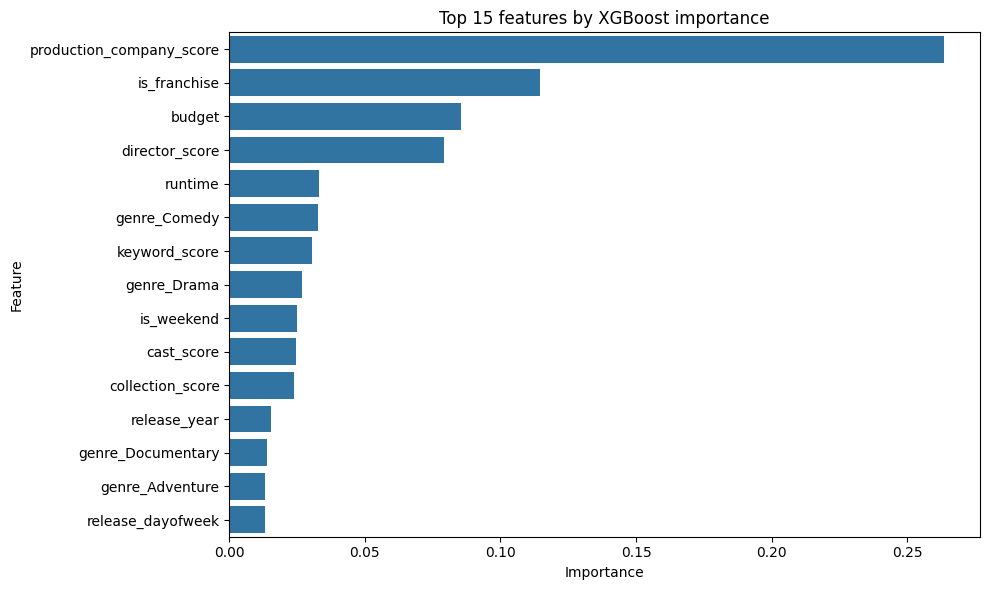

In [63]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_k = 15
display(importances.head(top_k).to_frame('importance'))

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(top_k).values, y=importances.head(top_k).index)
plt.title(f'Top {top_k} features by XGBoost importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 3) Khi nào là thời điểm tốt nhất để phát hành phim?
Trả lời theo 2 cách:
- **Thống kê lịch sử**: doanh thu theo tháng / quý / thứ trong tuần.
- **Mô phỏng bằng mô hình**: giữ nguyên các feature khác (median), thay đổi tháng để xem tháng nào dự đoán cao nhất.

,count,median,mean
release_month,,,
1,800,6134562.0,3.138834e+07
2,856,7900134.0,4.724697e+07
3,909,7875862.0,4.926160e+07
4,846,6744544.5,5.159663e+07
5,750,4704623.0,7.847416e+07
6,763,5639730.0,9.064110e+07
7,820,10927813.0,8.049623e+07
8,984,7148464.5,3.514734e+07
9,1331,4717597.0,3.017630e+07


,count,median,mean
release_dayofweek,,,
0,329,4500000.0,5.474086e+07
1,510,9820052.5,1.074540e+08
2,2188,13501816.5,1.018721e+08
3,2799,6535535.0,4.637766e+07
4,4386,4907757.5,3.134122e+07
5,678,6762904.5,4.033578e+07
6,297,2360281.0,4.119399e+07


,count,median,mean
release_month,,,
1,800,6134562.0,3.138834e+07
2,856,7900134.0,4.724697e+07
3,909,7875862.0,4.926160e+07
4,846,6744544.5,5.159663e+07
5,750,4704623.0,7.847416e+07
6,763,5639730.0,9.064110e+07
7,820,10927813.0,8.049623e+07
8,984,7148464.5,3.514734e+07
9,1331,4717597.0,3.017630e+07


,count,median,mean
release_dayofweek,,,
0,329,4500000.0,5.474086e+07
1,510,9820052.5,1.074540e+08
2,2188,13501816.5,1.018721e+08
3,2799,6535535.0,4.637766e+07
4,4386,4907757.5,3.134122e+07
5,678,6762904.5,4.033578e+07
6,297,2360281.0,4.119399e+07


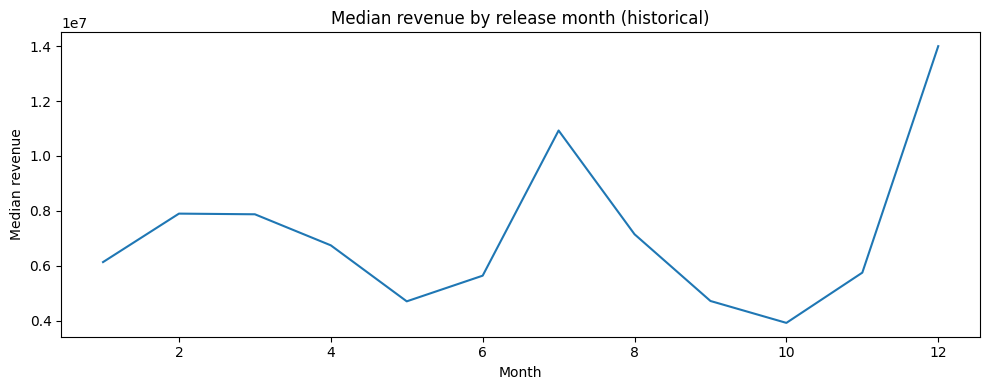

,count,median,mean
release_month,,,
1,800,6134562.0,3.138834e+07
2,856,7900134.0,4.724697e+07
3,909,7875862.0,4.926160e+07
4,846,6744544.5,5.159663e+07
5,750,4704623.0,7.847416e+07
6,763,5639730.0,9.064110e+07
7,820,10927813.0,8.049623e+07
8,984,7148464.5,3.514734e+07
9,1331,4717597.0,3.017630e+07


,count,median,mean
release_dayofweek,,,
0,329,4500000.0,5.474086e+07
1,510,9820052.5,1.074540e+08
2,2188,13501816.5,1.018721e+08
3,2799,6535535.0,4.637766e+07
4,4386,4907757.5,3.134122e+07
5,678,6762904.5,4.033578e+07
6,297,2360281.0,4.119399e+07


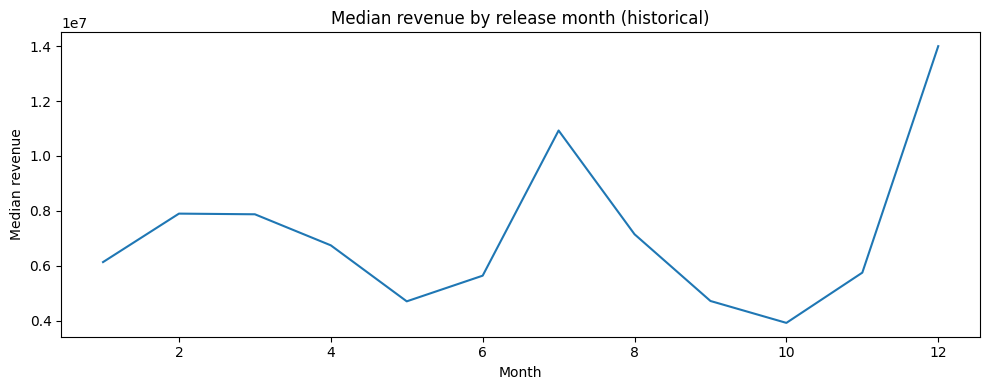

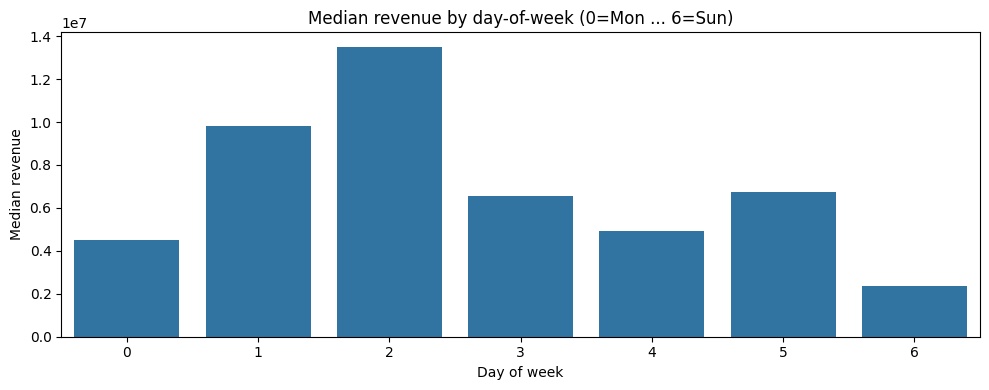

In [64]:
df_time = df_full.dropna(subset=['revenue_raw']).copy()
df_time['release_month'] = pd.to_numeric(df_time['release_month'], errors='coerce')
df_time['release_dayofweek'] = pd.to_numeric(df_time['release_dayofweek'], errors='coerce')

month_stats = df_time.groupby('release_month')['revenue_raw'].agg(['count', 'median', 'mean']).sort_index()
dow_stats = df_time.groupby('release_dayofweek')['revenue_raw'].agg(['count', 'median', 'mean']).sort_index()

display(month_stats)
display(dow_stats)

plt.figure(figsize=(10, 4))
sns.lineplot(x=month_stats.index, y=month_stats['median'])
plt.title('Median revenue by release month (historical)')
plt.xlabel('Month')
plt.ylabel('Median revenue')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x=dow_stats.index, y=dow_stats['median'])
plt.title('Median revenue by day-of-week (0=Mon ... 6=Sun)')
plt.xlabel('Day of week')
plt.ylabel('Median revenue')
plt.tight_layout()
plt.show()

Best month by model simulation (typical movie): 1


,month,predicted_revenue
0,1,2.751155e+06
1,2,2.751155e+06
2,3,2.614320e+06
11,12,2.592022e+06
6,7,2.564234e+06


Best month by model simulation (typical movie): 1


,month,predicted_revenue
0,1,2.751155e+06
1,2,2.751155e+06
2,3,2.614320e+06
11,12,2.592022e+06
6,7,2.564234e+06


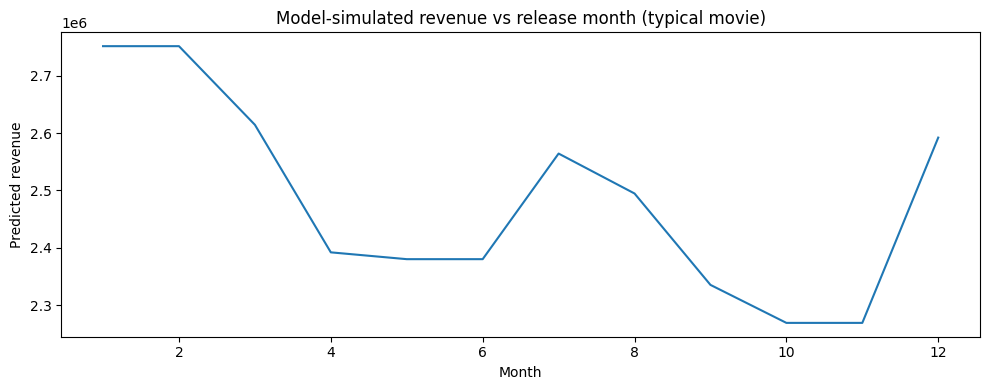

In [65]:
# Model-based simulation: vary month while keeping other features fixed at median
base = X.median(numeric_only=True).to_frame().T

def simulate_by_month(base_row):
    rows = []
    for m in range(1, 13):
        r = base_row.copy()
        if 'release_month' in r.columns:
            r.loc[r.index[0], 'release_month'] = m
        if 'release_quarter' in r.columns:
            r.loc[r.index[0], 'release_quarter'] = int((m - 1) / 3) + 1
        # keep a typical weekday release (Friday)
        if 'release_dayofweek' in r.columns:
            r.loc[r.index[0], 'release_dayofweek'] = 4
        if 'is_weekend' in r.columns:
            r.loc[r.index[0], 'is_weekend'] = 0
        if 'is_blockbuster_season' in r.columns:
            r.loc[r.index[0], 'is_blockbuster_season'] = 1 if m in [5, 6, 7, 11, 12] else 0

        yhat = float(model.predict(r)[0])
        rows.append({'month': m, 'predicted_revenue': float(np.expm1(yhat))})
    return pd.DataFrame(rows)

sim_month = simulate_by_month(base)
best_month = int(sim_month.sort_values('predicted_revenue', ascending=False).iloc[0]['month'])
print('Best month by model simulation (typical movie):', best_month)
display(sim_month.sort_values('predicted_revenue', ascending=False).head(5))

plt.figure(figsize=(10, 4))
sns.lineplot(data=sim_month, x='month', y='predicted_revenue')
plt.title('Model-simulated revenue vs release month (typical movie)')
plt.xlabel('Month')
plt.ylabel('Predicted revenue')
plt.tight_layout()
plt.show()

# 4) Studio nào đang thống trị doanh thu?
Phân tích trực tiếp trên dữ liệu gốc: `production_companies` (tách theo dấu phẩy), sau đó tính:
- Tổng doanh thu (sum)
- Doanh thu trung vị / trung bình mỗi phim
- Số lượng phim

,n_movies,revenue_sum,revenue_mean,revenue_median
production_companies,,,,
Warner Bros. Pictures,288,57896233332,2.010286e+08,98600000.0
Universal Pictures,322,54643012746,1.696988e+08,85264188.0
Columbia Pictures,267,51028160986,1.911167e+08,122810399.0
20th Century Fox,205,42299269664,2.063379e+08,134748021.0
Paramount Pictures,225,37543851502,1.668616e+08,99036827.0
Marvel Studios,39,32620663117,8.364273e+08,760900000.0
Walt Disney Pictures,119,29940835615,2.516037e+08,145358062.0
New Line Cinema,168,23598212217,1.404655e+08,80750000.0
TSG Entertainment,92,18842844865,2.048135e+08,102174576.5


,n_movies,revenue_sum,revenue_mean,revenue_median
production_companies,,,,
Warner Bros. Pictures,288,57896233332,2.010286e+08,98600000.0
Universal Pictures,322,54643012746,1.696988e+08,85264188.0
Columbia Pictures,267,51028160986,1.911167e+08,122810399.0
20th Century Fox,205,42299269664,2.063379e+08,134748021.0
Paramount Pictures,225,37543851502,1.668616e+08,99036827.0
Marvel Studios,39,32620663117,8.364273e+08,760900000.0
Walt Disney Pictures,119,29940835615,2.516037e+08,145358062.0
New Line Cinema,168,23598212217,1.404655e+08,80750000.0
TSG Entertainment,92,18842844865,2.048135e+08,102174576.5


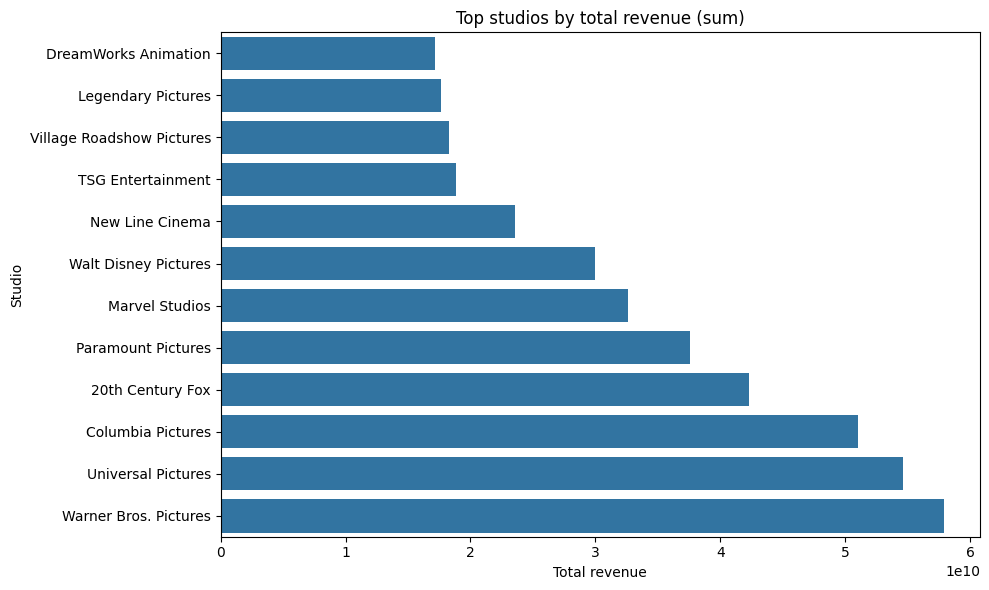

In [66]:
df_studio = df_raw[['production_companies', 'revenue']].copy()
df_studio['revenue_raw'] = pd.to_numeric(df_studio['revenue'], errors='coerce')
df_studio['production_companies'] = df_studio['production_companies'].apply(_parse_list_safe)

exploded = df_studio.explode('production_companies').dropna(subset=['production_companies', 'revenue_raw'])
exploded['production_companies'] = exploded['production_companies'].astype(str).str.strip()
exploded = exploded[exploded['production_companies'] != '']

studio_stats = exploded.groupby('production_companies')['revenue_raw'].agg(
    n_movies='count',
    revenue_sum='sum',
    revenue_mean='mean',
    revenue_median='median',
).sort_values('revenue_sum', ascending=False)

display(studio_stats.head(15))

plt.figure(figsize=(10, 6))
top_studios = studio_stats.head(12).iloc[::-1]
sns.barplot(x=top_studios['revenue_sum'], y=top_studios.index)
plt.title('Top studios by total revenue (sum)')
plt.xlabel('Total revenue')
plt.ylabel('Studio')
plt.tight_layout()
plt.show()

# 5) Nếu thêm một ngôi sao hạng A, doanh thu sẽ tăng bao nhiêu? Có đáng với chi phí thêm vào hay không?
Ý tưởng (xấp xỉ):
- Trong model, `cast_score` đại diện cho sức mạnh dàn cast dựa trên doanh thu lịch sử.
- Chọn “hạng A” = diễn viên có **doanh thu lịch sử trung bình** cao và đủ số mẫu.
- Mô phỏng: giữ nguyên feature khác (median), chỉ tăng `cast_score` lên mức của sao hạng A để xem doanh thu dự đoán tăng thêm.

**Đánh giá 'đáng hay không'**: notebook tính ngưỡng chi phí hoà vốn theo giả định phần doanh thu ròng studio nhận được `take_rate` (bạn có thể đổi).

In [67]:
# Build actor strength table from historical data (simple mean log revenue per actor)
df_actor = df_raw[['cast', 'revenue', 'release_date']].copy()
df_actor['revenue_raw'] = pd.to_numeric(df_actor['revenue'], errors='coerce').clip(lower=0)
df_actor['log_revenue'] = np.log1p(df_actor['revenue_raw'])
df_actor['cast_list'] = df_actor['cast'].apply(_parse_list_safe)

actor_exploded = df_actor.explode('cast_list').dropna(subset=['cast_list', 'log_revenue'])
actor_exploded['cast_list'] = actor_exploded['cast_list'].astype(str).str.strip()
actor_exploded = actor_exploded[actor_exploded['cast_list'] != '']

actor_strength = actor_exploded.groupby('cast_list')['log_revenue'].agg(
    n_movies='count',
    logrev_mean='mean',
    logrev_median='median',
).sort_values(['logrev_mean', 'n_movies'], ascending=False)

# Define A-list as actors with enough samples (>=5) and highest mean log revenue
a_list = actor_strength[actor_strength['n_movies'] >= 5].head(15)
display(a_list)

def estimate_star_uplift(actor_name, base_row=None, take_rate=0.5):
    """Return uplift estimates for adding an A-list actor to a 'typical' movie."""
    if base_row is None:
        base_row = X.median(numeric_only=True).to_frame().T
    base_row = base_row.copy()

    if 'cast_score' not in base_row.columns:
        raise ValueError('Feature cast_score not found in X')
    if actor_name not in actor_strength.index:
        raise ValueError('Actor not found in actor_strength table')

    actor_logrev = float(actor_strength.loc[actor_name, 'logrev_mean'])

    # baseline prediction
    y0 = float(model.predict(base_row)[0])
    r0 = float(np.expm1(y0))

    # uplift scenario: increase cast_score to at least actor strength
    base_row_star = base_row.copy()
    base_row_star.loc[base_row_star.index[0], 'cast_score'] = max(float(base_row_star['cast_score'].iloc[0]), actor_logrev)
    y1 = float(model.predict(base_row_star)[0])
    r1 = float(np.expm1(y1))

    delta = r1 - r0
    breakeven_cost = delta * take_rate
    return {
        'actor': actor_name,
        'baseline_revenue': r0,
        'revenue_with_star': r1,
        'delta_revenue': delta,
        'take_rate': take_rate,
        'breakeven_extra_cost': breakeven_cost,
        'actor_logrev_mean': actor_logrev,
    }

# Show uplift for top 5 A-list actors (on typical movie)
results = []
for actor in a_list.head(5).index:
    results.append(estimate_star_uplift(actor, take_rate=0.5))
uplift_df = pd.DataFrame(results).sort_values('delta_revenue', ascending=False)
display(uplift_df[['actor','baseline_revenue','revenue_with_star','delta_revenue','breakeven_extra_cost']])

print('Gợi ý đọc kết quả:')
print('- delta_revenue: doanh thu dự đoán tăng thêm (gross)')
print('- breakeven_extra_cost: mức chi phí thêm tối đa (với take_rate giả định) để còn hoà vốn')
print('Bạn có thể chỉnh take_rate trong estimate_star_uplift(..., take_rate=...) tùy giả định.')

,n_movies,logrev_mean,logrev_median
cast_list,,,
Zendaya,5,19.850321,19.944705
Miranda Cosgrove,6,19.840109,20.402767
Peter Cullen,8,19.788121,20.300904
Teng Shen,10,19.646694,19.803172
Tom Cruise,23,19.553801,19.697085
Jackson Yee,8,19.537337,19.213150
Craig T. Nelson,5,19.498760,19.575673
Chris Pratt,18,19.464132,19.443065
Seth MacFarlane,5,19.349968,19.190157


,n_movies,logrev_mean,logrev_median
cast_list,,,
Zendaya,5,19.850321,19.944705
Miranda Cosgrove,6,19.840109,20.402767
Peter Cullen,8,19.788121,20.300904
Teng Shen,10,19.646694,19.803172
Tom Cruise,23,19.553801,19.697085
Jackson Yee,8,19.537337,19.213150
Craig T. Nelson,5,19.498760,19.575673
Chris Pratt,18,19.464132,19.443065
Seth MacFarlane,5,19.349968,19.190157


,actor,baseline_revenue,revenue_with_star,delta_revenue,breakeven_extra_cost
0,Zendaya,2.851151e+06,3.375605e+06,524454.317146,262227.158573
1,Miranda Cosgrove,2.851151e+06,3.375605e+06,524454.317146,262227.158573
2,Peter Cullen,2.851151e+06,3.375605e+06,524454.317146,262227.158573
3,Teng Shen,2.851151e+06,3.375605e+06,524454.317146,262227.158573
4,Tom Cruise,2.851151e+06,3.375605e+06,524454.317146,262227.158573


Gợi ý đọc kết quả:
- delta_revenue: doanh thu dự đoán tăng thêm (gross)
- breakeven_extra_cost: mức chi phí thêm tối đa (với take_rate giả định) để còn hoà vốn
Bạn có thể chỉnh take_rate trong estimate_star_uplift(..., take_rate=...) tùy giả định.


# 6) Thể loại nào đang tăng trưởng doanh thu nhanh nhất?
Cách làm: explode `genres`, tính **median log(revenue)** theo năm cho từng genre, sau đó fit đường thẳng $log(revenue) = a + b \cdot year$. Genre có slope $b$ lớn nhất được xem là tăng trưởng nhanh nhất (trong dữ liệu).

,genre,slope_logrev_per_year,n_years_used
0,Action,-0.007399,25
1,Adventure,-0.031000,25
14,Science Fiction,-0.041812,25
4,Crime,-0.041904,25
9,History,-0.041968,25
6,Drama,-0.044028,25
10,Horror,-0.046601,25
2,Animation,-0.050013,25
5,Documentary,-0.051862,25
3,Comedy,-0.052323,25


,genre,slope_logrev_per_year,n_years_used
0,Action,-0.007399,25
1,Adventure,-0.031000,25
14,Science Fiction,-0.041812,25
4,Crime,-0.041904,25
9,History,-0.041968,25
6,Drama,-0.044028,25
10,Horror,-0.046601,25
2,Animation,-0.050013,25
5,Documentary,-0.051862,25
3,Comedy,-0.052323,25


Genre tăng trưởng nhanh nhất (theo slope log revenue): Action


,genre,slope_logrev_per_year,n_years_used
0,Action,-0.007399,25
1,Adventure,-0.031000,25
14,Science Fiction,-0.041812,25
4,Crime,-0.041904,25
9,History,-0.041968,25
6,Drama,-0.044028,25
10,Horror,-0.046601,25
2,Animation,-0.050013,25
5,Documentary,-0.051862,25
3,Comedy,-0.052323,25


Genre tăng trưởng nhanh nhất (theo slope log revenue): Action


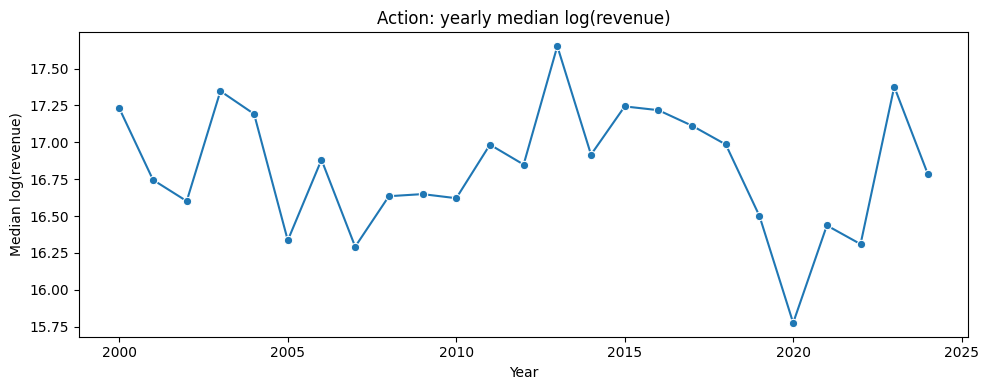

In [68]:
from sklearn.linear_model import LinearRegression

df_gen = df_raw[['genres', 'revenue', 'release_date']].copy()
df_gen['revenue_raw'] = pd.to_numeric(df_gen['revenue'], errors='coerce').clip(lower=0)
df_gen['log_revenue'] = np.log1p(df_gen['revenue_raw'])
df_gen['release_date'] = pd.to_datetime(df_gen['release_date'], errors='coerce')
df_gen['year'] = df_gen['release_date'].dt.year
df_gen['genres_list'] = df_gen['genres'].apply(_parse_list_safe)

df_gen = df_gen.dropna(subset=['year', 'log_revenue'])
gexp = df_gen.explode('genres_list').dropna(subset=['genres_list'])
gexp['genres_list'] = gexp['genres_list'].astype(str).str.strip()
gexp = gexp[gexp['genres_list'] != '']

# yearly median per genre
yearly = gexp.groupby(['genres_list', 'year'])['log_revenue'].agg(['count', 'median']).reset_index()

def fit_slope_for_genre(gname, min_year_points=5, min_movies_per_year=3):
    sub = yearly[(yearly['genres_list'] == gname) & (yearly['count'] >= min_movies_per_year)].copy()
    if len(sub) < min_year_points:
        return None
    Xy = sub[['year']].values
    yv = sub['median'].values
    lr = LinearRegression().fit(Xy, yv)
    return float(lr.coef_[0]), int(len(sub))

rows = []
for g in yearly['genres_list'].unique():
    out = fit_slope_for_genre(g)
    if out is None:
        continue
    slope, n_years = out
    rows.append({'genre': g, 'slope_logrev_per_year': slope, 'n_years_used': n_years})

growth = pd.DataFrame(rows).sort_values('slope_logrev_per_year', ascending=False)
display(growth.head(10))

if len(growth) > 0:
    best_genre = growth.iloc[0]['genre']
    print('Genre tăng trưởng nhanh nhất (theo slope log revenue):', best_genre)

    sub = yearly[(yearly['genres_list'] == best_genre) & (yearly['count'] >= 3)].copy()
    plt.figure(figsize=(10,4))
    sns.lineplot(data=sub, x='year', y='median', marker='o')
    plt.title(f'{best_genre}: yearly median log(revenue)')
    plt.xlabel('Year')
    plt.ylabel('Median log(revenue)')
    plt.tight_layout()
    plt.show()

## Tóm tắt nhanh (đọc sau khi chạy notebook)
- Câu 1: xem tỷ lệ thu lời theo dữ liệu + P(profit) cho phim điển hình.
- Câu 2: xem top feature importance (bar chart).
- Câu 3: xem thống kê lịch sử theo tháng/ngày + mô phỏng tháng tốt nhất theo model.
- Câu 4: xem bảng top studios theo tổng doanh thu.
- Câu 5: xem bảng uplift khi thêm sao hạng A + ngưỡng chi phí hoà vốn (tùy `take_rate`).
- Câu 6: xem genre có slope tăng trưởng lớn nhất.